# Multiclass Prediction of Obesity Risk

<h3>
  Analyze various factors to predict obesity risk in individuals, related to cardiovascular disease
</h3>

# import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
import warnings
warnings.warn('ignore')

/tmp/ipykernel_18/3203896045.py:8: UserWarning: ignore
  warnings.warn('ignore')


In [2]:
import os
import shutil
import sys
from glob import glob
import re
import math

In [3]:
# Required for PowerTransformer - any version below 1.3.1 returns ERROR 
# The algorithm terminated without finding a valid bracket
!pip install scikit-learn==1.3.2 --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 66.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.utils import compute_class_weight, compute_sample_weight
import scipy

2024-02-12 22:47:35.882021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 22:47:35.882144: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 22:47:36.029141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# datasets splits before analysis

In [5]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

# print columns to check
print(f'train_df columns:{train_df.columns} \n test_df columns:{test_df.columns}')

train_df columns:Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object') 
 test_df columns:Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS'],
      dtype='object')


In [6]:
# function to split trainXY and test_X
def create_datasets(trainxy, testx):
    # capture test_ids
    submit_id = testx['id']

    # Remove 'id' from dataseta
    testx = testx.drop(['id'], axis=1)
    trainx = trainxy.drop(['id'], axis=1)

    # split train_XY into train_X and train_Y
    trainy = trainx.NObeyesdad
    trainx.drop(['NObeyesdad'], axis=1, inplace=True)

    return trainx, trainy, testx, submit_id

In [7]:
# call create_datasets
train_X, train_Y, test_X, test_id = create_datasets(train_df, test_df)

# Initial Data Explortion

In [8]:
train_X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,20758.0,23.841804,5.688072,14.00,20.000000,22.815416,26.000000,61.000000
Height,20758.0,1.700245,0.087312,1.45,1.631856,1.700000,1.762887,1.975663
Weight,20758.0,87.887768,26.379443,39.00,66.000000,84.064875,111.600553,165.057269
FCVC,20758.0,2.445908,0.533218,1.00,2.000000,2.393837,3.000000,3.000000
NCP,20758.0,2.761332,0.705375,1.00,3.000000,3.000000,3.000000,4.000000
CH2O,20758.0,2.029418,0.608467,1.00,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.981747,0.838302,0.00,0.008013,1.000000,1.587406,3.000000
TUE,20758.0,0.616756,0.602113,0.00,0.000000,0.573887,1.000000,2.000000


In [9]:
train_X.info(show_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 16 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Gender                          object 
 1   Age                             float64
 2   Height                          float64
 3   Weight                          float64
 4   family_history_with_overweight  object 
 5   FAVC                            object 
 6   FCVC                            float64
 7   NCP                             float64
 8   CAEC                            object 
 9   SMOKE                           object 
 10  CH2O                            float64
 11  SCC                             object 
 12  FAF                             float64
 13  TUE                             float64
 14  CALC                            object 
 15  MTRANS                          object 
dtypes: float64(8), object(8)
memory usage: 2.5+ MB


In [10]:
print(train_X.isnull().sum() !=0)

Gender                            False
Age                               False
Height                            False
Weight                            False
family_history_with_overweight    False
FAVC                              False
FCVC                              False
NCP                               False
CAEC                              False
SMOKE                             False
CH2O                              False
SCC                               False
FAF                               False
TUE                               False
CALC                              False
MTRANS                            False
dtype: bool


In [11]:
print(test_X.isnull().sum() !=0)

Gender                            False
Age                               False
Height                            False
Weight                            False
family_history_with_overweight    False
FAVC                              False
FCVC                              False
NCP                               False
CAEC                              False
SMOKE                             False
CH2O                              False
SCC                               False
FAF                               False
TUE                               False
CALC                              False
MTRANS                            False
dtype: bool


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

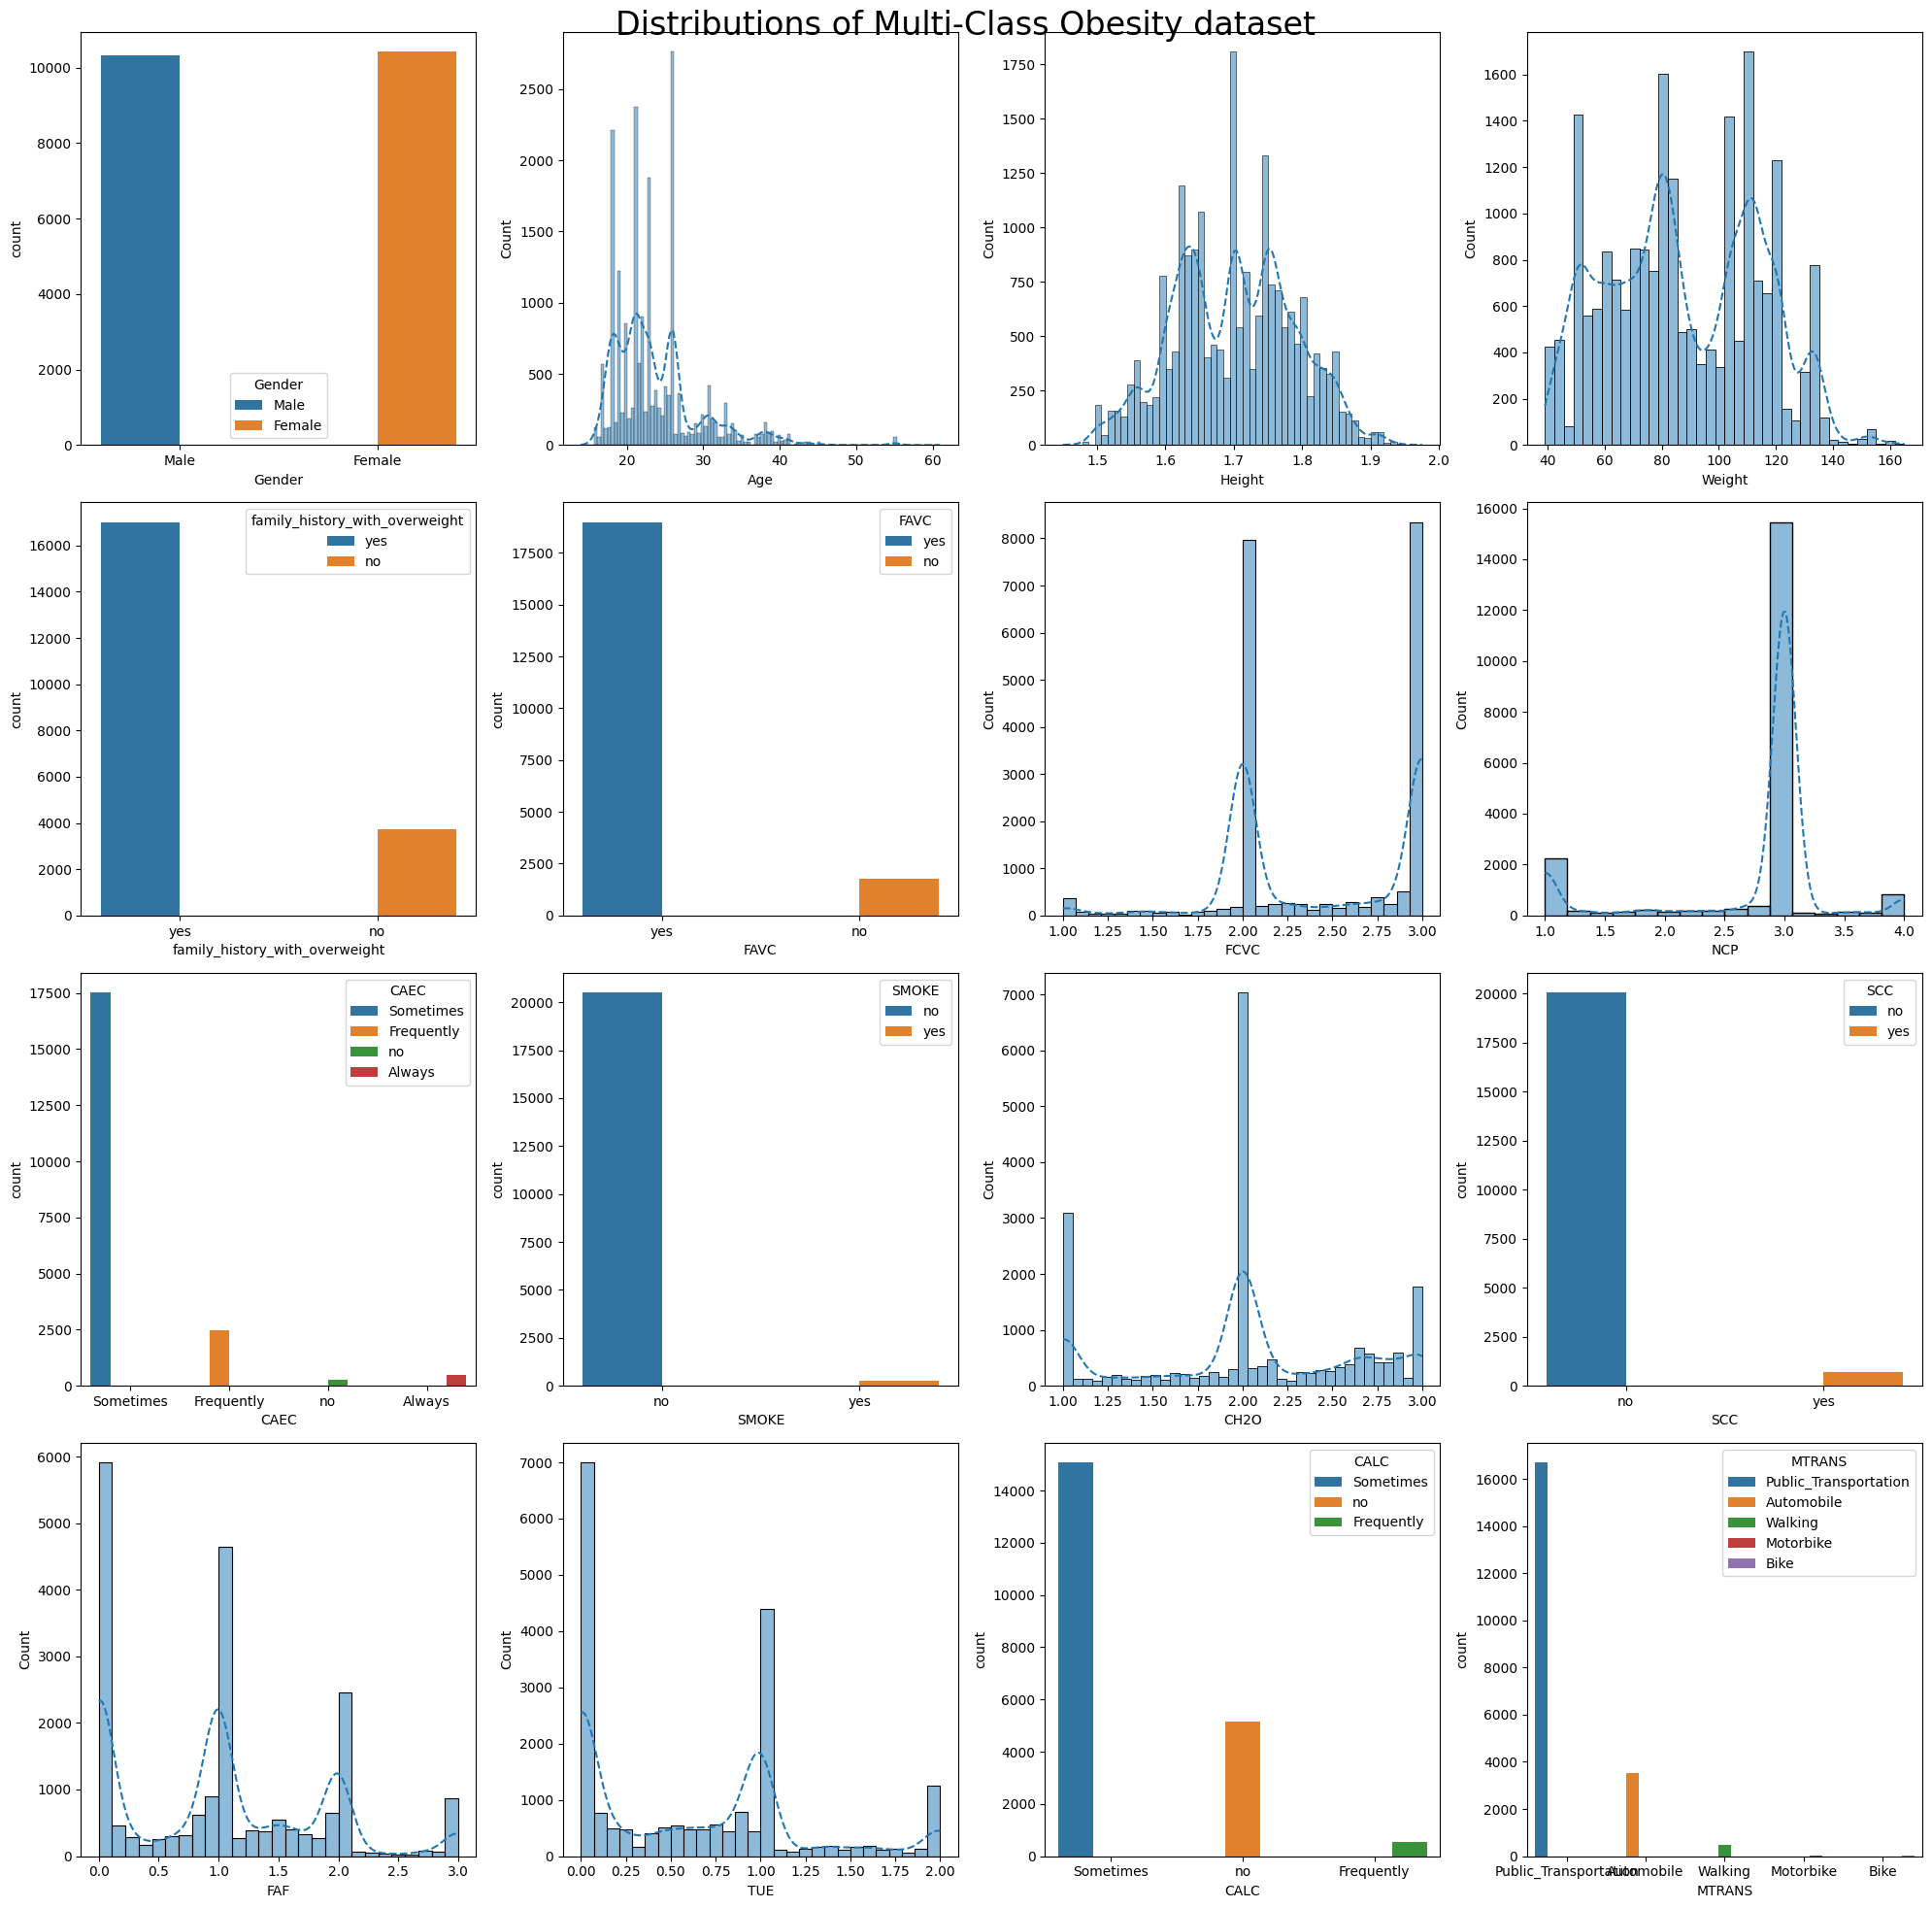

In [12]:
# Plot all features
cols = 4
rows = int(math.ceil(len(train_X.columns) / cols))

fig,ax = plt.subplots(nrows=rows,ncols=cols,figsize=(20,20))
ax = ax.flatten()

plt.suptitle("Distributions of Multi-Class Obesity dataset",size=24)

for i,col in enumerate(train_X.columns):
    if train_X[col].dtype == float or train_X[col].dtype == int:
        sns.histplot(data=train_X,x=col,ax=ax[i],kde=True,line_kws={"ls":"--"})
    else:
        sns.countplot(data=train_X,x=col,ax=ax[i], hue=col)
        # ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

# Preprocessing Datasets for Analysis and Prediction

In [13]:
X_cluster = pd.get_dummies(train_X)
X_test_cluster = pd.get_dummies(test_X)
col_name = X_test_cluster.columns  # this is so oreder of column names match

In [14]:
ind = X_test_cluster.columns.get_loc('CALC_Always')
X_cluster.insert(loc=ind, column='CALC_Always', value=False)
X_cluster.shape, X_test_cluster.shape

((20758, 31), (13840, 31))

In [15]:
X_cluster.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,False,True,...,False,False,False,True,False,False,False,False,True,False
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,True,False,...,False,False,False,False,True,True,False,False,False,False
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,True,False,...,False,False,False,False,True,False,False,False,True,False
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,True,False,...,False,False,False,True,False,False,False,False,True,False
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,False,True,...,False,False,False,True,False,False,False,False,True,False


In [16]:
X_test_cluster.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,26.899886,1.848294,120.644178,2.938616,3.000000,2.825629,0.855400,0.000000,False,True,...,False,False,False,True,False,False,False,False,True,False
1,21.000000,1.600000,66.000000,2.000000,1.000000,3.000000,1.000000,0.000000,True,False,...,False,False,False,True,False,False,False,False,True,False
2,26.000000,1.643355,111.600553,3.000000,3.000000,2.621877,0.000000,0.250502,True,False,...,False,False,False,True,False,False,False,False,True,False
3,20.979254,1.553127,103.669116,2.000000,2.977909,2.786417,0.094851,0.000000,False,True,...,False,False,False,True,False,False,False,False,True,False
4,26.000000,1.627396,104.835346,3.000000,3.000000,2.653531,0.000000,0.741069,True,False,...,False,False,False,True,False,False,False,False,True,False


In [17]:
scaler = PowerTransformer()
X_cluster = scaler.fit_transform(X_cluster)
X_test_cluster = scaler.transform(X_test_cluster)

In [18]:
type(X_cluster), type(X_test_cluster), X_cluster.shape, X_test_cluster.shape

(numpy.ndarray, numpy.ndarray, (20758, 31), (13840, 31))

In [19]:
X_cluster_pd = pd.DataFrame(X_cluster, columns=col_name)

In [20]:
X_cluster_pd.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Female,Gender_Male,...,SCC_yes,CALC_Always,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.392273,0.001826,-0.180944,-0.882621,0.182365,1.232230,-1.320341,0.775163,-1.004152,1.004152,...,-0.185009,0.0,-0.161711,0.614658,-0.575385,-0.452967,-0.039293,-0.042825,0.493925,-0.151707
1,-1.379784,-1.613755,-1.189908,-0.882621,0.217247,-0.084861,0.200903,0.804524,0.995866,-0.995866,...,-0.185009,0.0,-0.161711,-1.626921,1.737967,2.207668,-0.039293,-0.042825,-2.024597,-0.151707
2,-1.379784,0.133016,-1.495630,-1.077494,-1.817734,-0.232407,0.041157,1.483281,0.995866,-0.995866,...,-0.185009,0.0,-0.161711,-1.626921,1.737967,-0.452967,-0.039293,-0.042825,0.493925,-0.151707
3,-0.403279,0.124665,1.562234,1.072753,0.217247,-0.613803,0.696094,0.509587,0.995866,-0.995866,...,-0.185009,0.0,-0.161711,0.614658,-0.575385,-0.452967,-0.039293,-0.042825,0.493925,-0.151707
4,1.384082,2.427755,0.274031,0.383134,-1.357225,-0.118174,1.144539,0.717945,-1.004152,1.004152,...,-0.185009,0.0,-0.161711,0.614658,-0.575385,-0.452967,-0.039293,-0.042825,0.493925,-0.151707


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

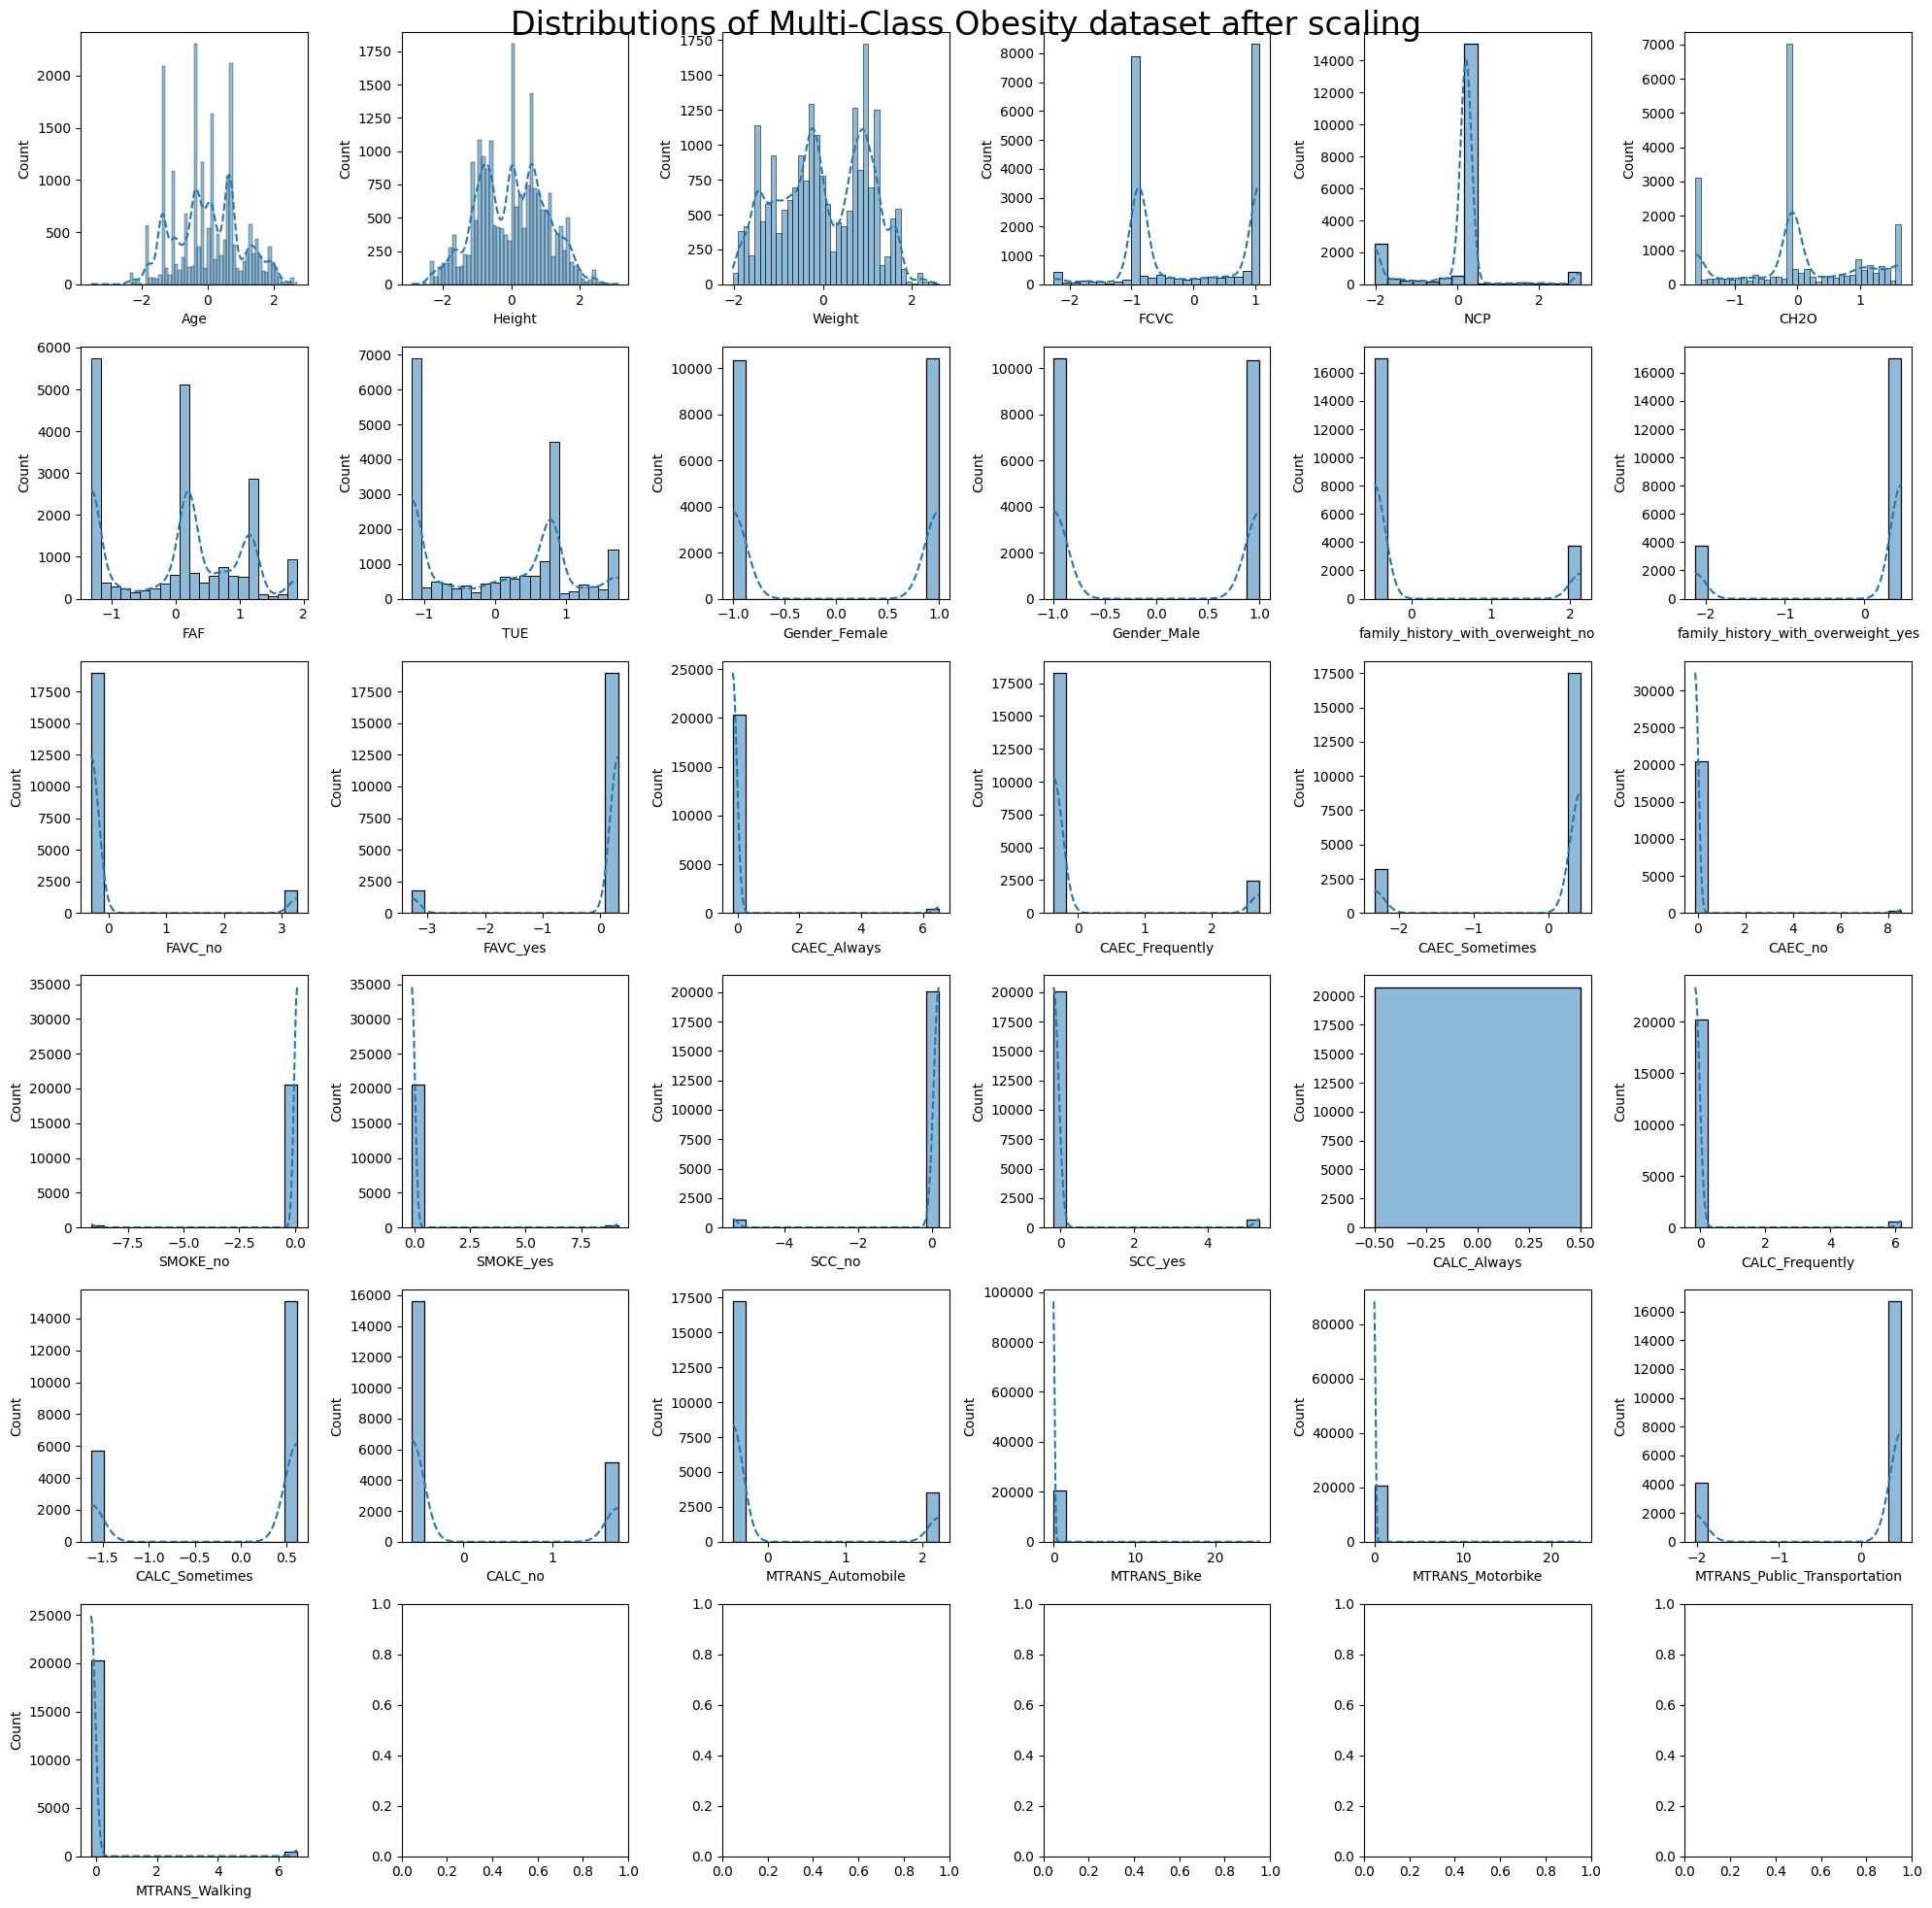

In [21]:
# Plot all after transformation and scaling - number is 31
cols = 6
rows = int(math.ceil(len(X_cluster_pd.columns) / cols))

fig,ax = plt.subplots(nrows=rows,ncols=cols,figsize=(20,20))
ax = ax.flatten()

plt.suptitle("Distributions of Multi-Class Obesity dataset after scaling",size=24)

for i,col in enumerate(X_cluster_pd.columns):
    if X_cluster_pd[col].dtype == float or X_cluster_pd[col].dtype == int:
        sns.histplot(data=X_cluster_pd,x=col,ax=ax[i],kde=True,line_kws={"ls":"--"})
    else:
        pass

plt.tight_layout()
plt.show()

In [22]:
# Create a classweight dictionary
classes = train_Y.unique()
classweight = compute_class_weight(class_weight="balanced",classes=classes,y=train_Y)

classweight_dict = {}
for idx,weight in enumerate(classweight):
    classweight_dict[idx] = weight / classweight[0]

classweight_dict

{0: 1.0,
 1: 0.81829980532122,
 2: 0.9996036464526358,
 3: 0.6233316856154226,
 4: 0.7764778325123152,
 5: 1.0391429748660899,
 6: 0.8666666666666666}

In [23]:
labelEnc = LabelEncoder()
y_encoded = labelEnc.fit_transform(train_Y)

y = tf.keras.utils.to_categorical(y_encoded)

In [24]:
X = X_cluster.copy()
X_test = X_test_cluster.copy()

In [25]:
# ref: https://www.kaggle.com/code/barbagrande007/bbg007-s4e2-obesity
# Add jittering. Introduce noise to X to reduce overfitting
X_jitter1 = X + np.random.uniform(0, 0.05, size=X.shape)
X_jitter2 = X + np.random.uniform(0, 0.1, size=X.shape)
X_jitter3 = X + np.random.uniform(0, 0.15, size=X.shape)
X_jitter4 = X + np.random.uniform(0, 0.2, size=X.shape)
X = np.vstack((X,X_jitter1,X_jitter2,X_jitter3,X_jitter4))

# Duplicate y
y = np.vstack((y,y,y,y,y))

# Randomize samples
shuffled_indices = np.random.permutation(len(X))
X = X[shuffled_indices]
y = y[shuffled_indices]

# split datasets into three - training, val, and hold_out

In [26]:
trainX, valXX, trainY, valYY = train_test_split(X, y,
                                                test_size=0.33,
                                               shuffle=True,
                                               random_state=42)

In [27]:
valX, testX, valY, testY = train_test_split(valXX, valYY,
                                                test_size=0.5,
                                               shuffle=True,
                                               random_state=42)

In [28]:
# check shapes of all 3 sets
print(f'Train: X:{trainX.shape} Y:{trainY.shape}')
print(f'Val  : X:{valX.shape}   Y:{valY.shape}')
print(f'Test : X:{testX.shape}  Y:{testY.shape}')

Train: X:(69539, 31) Y:(69539, 7)
Val  : X:(17125, 31)   Y:(17125, 7)
Test : X:(17126, 31)  Y:(17126, 7)


# Deep Neural Network - Tensorflow -> Keras

In [29]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.models import Model, Sequential
import keras.backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.regularizers import L1, L2, L1L2
from keras.layers import ReLU, LeakyReLU
from keras.optimizers import Adam, SGD

In [30]:
# values to coerce building a good NN - Fully connected - Dense layer network
batch_size = 32
num_classes = trainY.shape[1]
tr_shape = trainX.shape[1]
l1_reg = 0.01
l2_reg = 0.01
l1_l2_reg =  0.023
initializer='glorot_uniform'

# Use a learning_rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, 
                                                             decay_steps=100, 
                                                             decay_rate=0.9)
opt = Adam(learning_rate=lr_schedule)

In [31]:
def build_seq_model(tr_shape=tr_shape, nlayer1=60, n_layer2=1.5,
                    l1_reg=l1_reg, l2_reg=l2_reg, l1_l2_reg=l1_l2_reg,
                    initializer=initializer, opt=opt,
                   ):
    K.clear_session()
    # nlayer1 = nlayer1 // batch_size
    m_layer2 = math.ceil(nlayer1 * n_layer2)

    model = Sequential()

    #### ONE ####
    model.add(Dense(nlayer1, input_shape=(tr_shape,), activation='relu',
                  kernel_regularizer=L2(l2_reg),
                  kernel_initializer = initializer,
                 ))  # cal number of layers based on
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    #### TWO ####
    model.add(Dense(m_layer2, activation='relu',
           kernel_regularizer=L2(l2_reg),
            kernel_initializer=initializer,
           )) # increase number of layer and drop in next one
    model.add(Dropout(0.3))

    #### OUT ####
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'],
               )

    return model

# callbacks - basic hyperparameters

In [32]:
# ModelCheckpoint
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='obesity.hd5',
    save_weights_only=True,         # only save weights
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
)

In [33]:
# Reduce Learning Rate
# Giving ERROR when enabled - doesn't work when assigning Learning_Rate to Adam
reduce_lr = ReduceLROnPlateau(
  monitor='val_loss',
  factor=0.04,
  patience=5,
  min_lr=0.0,
)

In [34]:
# Early Stopping
early_stop = EarlyStopping(
  monitor='val_loss',
  mode='auto',
  verbose=0,
  patience=3,
)

In [35]:
# build model - hyperparamter values to improve accuacy
nlayer=train_X.shape[0] // 2
nlayer1 = 560      # 80  3 mistakenly typed '560' and accuacy shotup on hold-out
n_layer2=1.3
tr_shape = trainX.shape[1]
l1_reg = 0.01
l2_reg = 0.001    # 0.01  0.001 is good
l1_l2_reg =  0.023
initializer='glorot_uniform'

# Use a learning_rate schedule
from tensorflow.keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(initial_learning_rate=0.01, 
                               decay_steps=122,   # 122
                               decay_rate=0.8)    # 0.8
opt = Adam(learning_rate=lr_schedule)

model = build_seq_model(tr_shape=tr_shape, nlayer1=nlayer1, n_layer2=n_layer2,
                    l1_reg=l1_reg, l2_reg=l2_reg, l1_l2_reg=l1_l2_reg,
                    initializer=initializer, opt=opt)
                    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 560)               17920     
                                                                 
 dropout (Dropout)           (None, 560)               0         
                                                                 
 batch_normalization (Batch  (None, 560)               2240      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 728)               408408    
                                                                 
 dropout_1 (Dropout)         (None, 728)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                 5103      
                                                        

In [36]:
epochs = 60
batch_size=1024   # 1024  # 2048  # 1536 # 3072

history = model.fit(trainX, trainY,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(valX,valY),
          ## callbacks=[model_checkpoint_callback, reduce_lr, early_stop],
          callbacks=[model_checkpoint_callback, early_stop],
         verbose=1,
         )

Epoch 1/60
68/68 [==============================] - 5s 47ms/step - loss: 1.4550 - accuracy: 0.7598 - val_loss: 1.0090 - val_accuracy: 0.8141
Epoch 2/60
68/68 [==============================] - 3s 45ms/step - loss: 0.6189 - accuracy: 0.8419 - val_loss: 0.7421 - val_accuracy: 0.8413
Epoch 3/60
68/68 [==============================] - 3s 43ms/step - loss: 0.5518 - accuracy: 0.8498 - val_loss: 0.6196 - val_accuracy: 0.8672
Epoch 4/60
68/68 [==============================] - 3s 42ms/step - loss: 0.5286 - accuracy: 0.8534 - val_loss: 0.5674 - val_accuracy: 0.8639
Epoch 5/60
68/68 [==============================] - 3s 44ms/step - loss: 0.5047 - accuracy: 0.8590 - val_loss: 0.5056 - val_accuracy: 0.8683
Epoch 6/60
68/68 [==============================] - 3s 43ms/step - loss: 0.4869 - accuracy: 0.8629 - val_loss: 0.4670 - val_accuracy: 0.8751
Epoch 7/60
68/68 [==============================] - 3s 43ms/step - loss: 0.4748 - accuracy: 0.8650 - val_loss: 0.4487 - val_accuracy: 0.8787
Epoch 8/60
68

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

Text(0.5, 1.0, 'Accuracy')

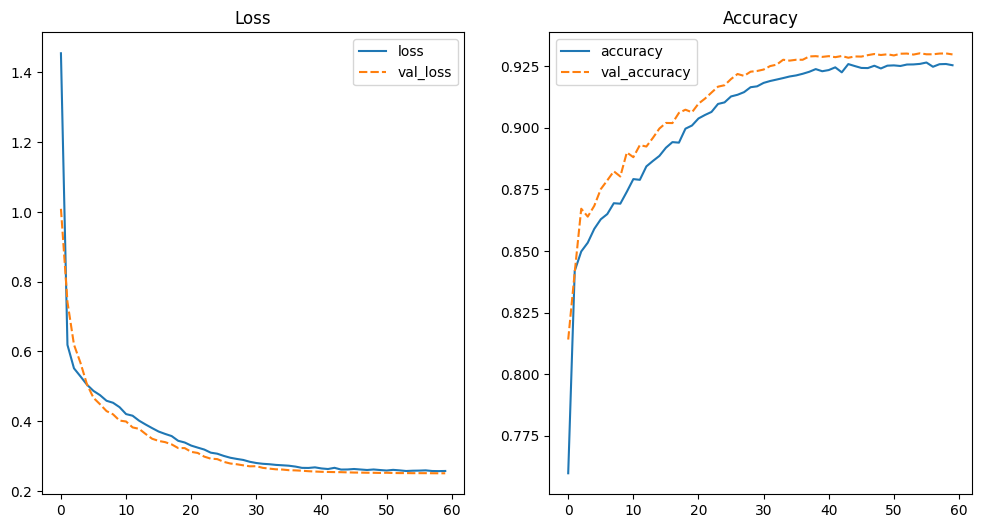

In [37]:
hist_frame=pd.DataFrame(data=history.history)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.lineplot(data=(hist_frame.loss, hist_frame.val_loss))
plt.title('Loss')
plt.subplot(1,2,2)
sns.lineplot(data=(hist_frame.accuracy, hist_frame.val_accuracy))
plt.title('Accuracy')

# evaluate on validation and predict on test split hold-out

In [38]:
model.evaluate(valX, valY, batch_size=32)

536/536 [==============================] - 1s 2ms/step - loss: 0.2508 - accuracy: 0.9298


[0.25076955556869507, 0.9297518134117126]

In [39]:
test_predictions = model.predict(testX)

536/536 [==============================] - 1s 2ms/step


In [40]:
predictions=[]
for i in range(len(test_predictions)):
  # print("Predicted=%s" % np.argmax(test_predictions[i]))
  predictions.append(np.argmax(test_predictions[i]))

In [41]:
# convert testY to true_labels
testY_actual=[]
for i in range(len(testY)):
    testY_actual.append(np.argmax(testY[i]))

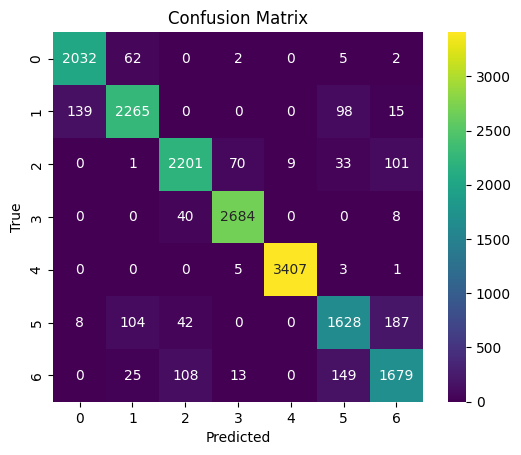

In [42]:
sns.heatmap(confusion_matrix(testY_actual, predictions), annot=True, cmap='viridis', fmt='d', square=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [43]:
print(classification_report(testY_actual, predictions))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      2103
           1       0.92      0.90      0.91      2517
           2       0.92      0.91      0.92      2415
           3       0.97      0.98      0.97      2732
           4       1.00      1.00      1.00      3416
           5       0.85      0.83      0.84      1969
           6       0.84      0.85      0.85      1974

    accuracy                           0.93     17126
   macro avg       0.92      0.92      0.92     17126
weighted avg       0.93      0.93      0.93     17126



# inference for Multi-Class Prediction of Obesity Risk

In [44]:
# predictions_ = model.predict(X_test_cluster)
predictions_ = model.predict(X_test_cluster)

predictions_[:5]

predictions_max=[]
for i in range(len(predictions_)):
    predictions_max.append(np.argmax(predictions_[i]))

# predictions_max[:10]

# Inverse label encoder
predictions = labelEnc.inverse_transform(predictions_max)
predictions[:5]

433/433 [==============================] - 1s 2ms/step


array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III',
       'Obesity_Type_I', 'Obesity_Type_III'], dtype=object)

In [45]:
# create DataFrame to write CSV file
predictions_data = pd.DataFrame(predictions, columns=['NObeyesdad'])
predictions_data.insert(0, 'id', test_id)
predictions_data.to_csv('submission.csv', index = False)

predictions_data.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


In [46]:
!head -10 submission.csv

id,NObeyesdad
20758,Obesity_Type_II
20759,Overweight_Level_I
20760,Obesity_Type_III
20761,Obesity_Type_I
20762,Obesity_Type_III
20763,Insufficient_Weight
20764,Insufficient_Weight
20765,Normal_Weight
20766,Overweight_Level_II


## end inference

<block><pre>
@misc{playground-series-s4e2,
    author = {Walter Reade, Ashley Chow},
    title = {Multi-Class Prediction of Obesity Risk},
    publisher = {Kaggle},
    year = {2024},
    url = {https://kaggle.com/competitions/playground-series-s4e2}
}
</block></pre>